In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

#torch.set_printoptions(2) 设置在打印浮点数张量时小数点后要打印的位数。
torch.set_printoptions(2)

In [2]:
#在每个像素点上都生成一组锚框，每组锚框都是由（s1,r1）、(s1,r2)....(s1,rn),(s2,r1)、(s3,r1).....(sm,r1),这m+n-1个组合控制形状大小，
#s为缩放比，r为宽高比，具体计算时有的用到了经验公式，只要让每组框的形状大小多样就可以，并不一定要用原来的公式计算s和r（w、h）
def multibox_prior(data,sizes,ratios):
    in_height,in_width=data.shape[-2:]
    device,num_sizes,num_ratios=data.device,len(sizes),len(ratios)
    boxes_per_pixel=(num_sizes+num_ratios-1)
    size_tensor=torch.tensor(sizes,device=device)
    ratio_tensor=torch.tensor(ratios,device=device)
    
    offset_x,offset_y=0.5,0.5
    step_x,step_y=1.0/in_width,1.0/in_height
    center_x=(torch.arange(in_width)+offset_x)*step_x
    center_y=(torch.arange(in_height)+offset_y)*step_y
    #用于后面获取每个像素点的中心坐标
    shift_y,shift_x=torch.meshgrid(center_y,center_x)
    shift_y,shift_x=shift_y.reshape(-1),shift_x.reshape(-1)
    
    #一组锚框的高和宽
    w=torch.cat((size_tensor*torch.sqrt(ratio_tensor[0]),sizes[0]*torch.sqrt(ratio_tensor[1:])))\
                    *in_height/in_width
    h=torch.cat((size_tensor/torch.sqrt(ratio_tensor[0]),sizes[0]/torch.sqrt(ratio_tensor[1:])))
    
    out_grid=torch.stack([shift_x,shift_y,shift_x,shift_y],dim=-1).repeat_interleave(boxes_per_pixel,dim=0)
    corner_shift=torch.stack([-w,-h,w,h]).T.repeat(in_height*in_width,1)/2
    outputs=out_grid+corner_shift
    return outputs.unsqueeze(0)

In [3]:
img=d2l.plt.imread('../img/catdog.jpg')
h,w=img.shape[:2]
print(h,w)
X=torch.rand(size=(1,3,h,w))
Y=multibox_prior(X,[0.75,0.5,0.25],[1,2,0.5])
Y.shape

599 800


torch.Size([1, 2396000, 4])

In [4]:
Y=Y.reshape(h,w,5,4)
Y[250,250,0,:]

tensor([0.03, 0.04, 0.59, 0.79])

In [5]:
def show_bboxes(axes,bboxes,labels=None,colors=None):
    def _make_list(obj,default_values=None):
        if obj is None:
            obj=default_values
        elif not isinstance(obj,(list,tuple)):
            obj = [obj]
        return obj
    labels=_make_list(labels)
    colors=_make_list(colors,['b','g','r','m','c'])
    for i,bbox in enumerate(bboxes):
        color=colors[i%len(colors)]
        rect=d2l.bbox_to_rect(bbox.detach().numpy(),color)
        axes.add_patch(rect)
        if labels and i<len(labels):
            text_color='k' if color == 'w' else 'w'
            axes.text(rect.xy[0],rect.xy[1],labels[i],
                     va='center',ha='center',fontsize=9,color=text_color,
                     bbox=dict(facecolor=color,lw=0))

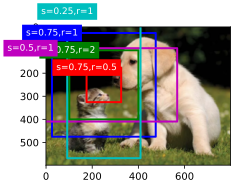

In [6]:
d2l.set_figsize()
bbox_scale=torch.tensor((w,h,w,h))
fig=d2l.plt.imshow(img)
show_bboxes(fig.axes,Y[250,250,:,:]*bbox_scale,
            labels=['s=0.75,r=1','s=0.75,r=2','s=0.75,r=0.5','s=0.5,r=1','s=0.25,r=1'])

#X=torch.tensor(img)
#X=torch.stack([X[:,:,0],X[:,:,1],X[:,:,2]],dim=0)
#print(X.shape)
#bboxes1=multibox_prior(X,[0.7,0.5,0.2],[1,2,0.5])
#bboxes1=bboxes1.reshape((X.shape[1],X.shape[2],5,4))
#fig=d2l.plt.imshow(img)
#show_bboxes(fig.axes,bboxes1[25,25,:,:]*bbox_scale,
#            labels=['s=0.7,r=1','s=0.7,r=2','s=0.7,r=0.5','s=0.5,r=1','s=0.2,r=1'])

In [7]:
#计算每个boxes1（N,4）对应每个boxes2(M,4)的交并比，返回一个形状为(N,M)的张量
def box_iou(boxes1,boxes2):
    #传进来的boxes形状为[n,4],每个box都包含左上角和右下角的坐标
    boxes_area=lambda boxes:(boxes[:,2]-boxes[:,0])*(boxes[:,3]-boxes[:,1])
    
    #获取交集的左上和右下角
    #左上角的点比较，右下角的点比较得出
    #假设boxes1和boxes2的形状分别是（N,4）,(M,4)
    inter_upleft=torch.max(boxes1[:,None,:2],boxes2[:,:2])   #（N，M，2）
    inter_downright=torch.min(boxes1[:,None,2:],boxes2[:,2:])
    #计算交区的宽和高，并截断掉那些空集
    inters=(inter_downright-inter_upleft).clamp(min=0)
    #计算交集的面积
    inter_areas=inters[:,:,0]*inters[:,:,1]
    
    #计算并集的面积
    areas1=boxes_area(boxes1)
    areas2=boxes_area(boxes2)
    #利用广播机制计算并集的面积
    union_areas=areas1[:,None]+areas2-inter_areas
    return inter_areas/union_areas

In [8]:
#为anchors分配ground_truth
#输出每个锚框对应的真实框
def assign_anchor_to_bbox(ground_truth,anchors,device,iou_threshold=0.5):
    num_anchors,num_gt_boxes=anchors.shape[0],ground_truth.shape[0]
    jaccard=box_iou(anchors,ground_truth)  #（num_anchors,num_ground_truth）
    anc_iou_max,indices=torch.max(jaccard,dim=1)  #计算每一行(每个锚框)最大的iou、下标
    #下面将小于阈值的anchor设置为-1,并部署到设备上去,下面的代码与原文代码作用是一样的
    anchor_box_map=torch.full((num_anchors,),-1,dtype=torch.long,device=device)
    anchor_box_map[anc_iou_max>=iou_threshold]=indices[anc_iou_max>=iou_threshold]
    #丢弃列、丢弃行
    col_discard=torch.full((num_anchors,),-1)
    row_discard=torch.full((num_gt_boxes,),-1)
    #逐个找出最大的iou删除行和列，直到删完所有的iou
    for _ in range(num_gt_boxes):
        max_idx=torch.argmax(jaccard)
        idx_i=(max_idx/num_gt_boxes).long()  #获取行
        idx_j=(max_idx%num_gt_boxes).long()  #获取列
        anchor_box_map[idx_i]=idx_j
        jaccard[idx_i,:]=row_discard
        jaccard[:,idx_j]=col_discard
    return anchor_box_map


In [9]:
#输入锚框和对应的真实框得出偏移量
def offset_boxes(anchors,assigned_bb,eps=1e-6):
    c_anchors=d2l.box_corner_to_center(anchors)
    c_bb=d2l.box_corner_to_center(assigned_bb)
    offset_xy=10*(c_bb[:,:2]-c_anchors[:,:2])/c_anchors[:,2:]
    offset_wh=5*torch.log(c_bb[:,2:]/c_anchors[:,2:]+eps)
    offset=torch.cat([offset_xy,offset_wh],dim=1)
    return offset

In [10]:
#输入锚框和真实框（标签）
#得出每个anchors与其对应的真实框的偏移、掩码mask（iou是否高于阈值）、类别
def multibox_target(anchors,labels):
    batch_size,anchors=labels.shape[0],anchors.squeeze(0)
    batch_offset,batch_mask,batch_class_labels=[],[],[]
    device,num_anchors=anchors.device,anchors.shape[0]
    for i in range(batch_size):
        label=labels[i,:,:]
        anchor_box_map=assign_anchor_to_bbox(label[:,1:],anchors,device)
        mask=(anchor_box_map>=0).float().unsqueeze(-1).repeat(1,4)
        class_labels=torch.full((num_anchors,),0,dtype=torch.long,device=device)
        assigned_bb=torch.zeros((num_anchors,4),dtype=torch.float32,device=device)
        indices_true=torch.nonzero(anchor_box_map>=0)
        class_labels[indices_true]=label[anchor_box_map[indices_true],0].long()+1
        assigned_bb[indices_true]=label[anchor_box_map[indices_true],1:]
        print(label.shape,assigned_bb.shape,anchor_box_map[indices_true])
        offset=offset_boxes(anchors,assigned_bb)*mask
        
        batch_offset.append(offset.reshape(-1))
        batch_class_labels.append(class_labels)
        batch_mask.append(mask.reshape(-1))
        
    offsets=torch.stack(batch_offset,dim=0)
    class_labels=torch.stack(batch_class_labels,dim=0)
    masks=torch.stack(batch_mask,dim=0)
    return (offsets,masks,class_labels)

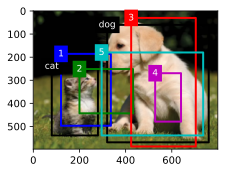

In [70]:
#ground_truth的0，1表示狗、猫，使用corner确定rect
#锚框的0、1、2表示背景、狗、猫
ground_truth=torch.tensor([[1,0.1,0.4,0.35,0.9],[0,0.4,0.1,0.95,0.95]])
anchors=torch.tensor([[0.15, 0.31, 0.42, 0.83], [0.25, 0.42, 0.54, 0.74],
                    [0.53, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.37, 0.3, 0.92, 0.9]])

fig=d2l.plt.imshow(img)
show_bboxes(fig.axes,ground_truth[:,1:]*bbox_scale,['cat','dog'],'k')
show_bboxes(fig.axes,anchors*bbox_scale,['1','2','3','4','5'])

In [12]:
labels=multibox_target(anchors.unsqueeze(dim=0),
                      ground_truth.unsqueeze(dim=0))

torch.Size([2, 5]) torch.Size([5, 4]) tensor([[0],
        [1],
        [1]])


In [13]:
labels[2]

tensor([[2, 0, 1, 0, 1]])

In [14]:
labels[1]

tensor([[1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [15]:
labels[0]

tensor([[-2.22e+00,  1.54e+00, -3.85e-01, -1.96e-01, -0.00e+00, -0.00e+00,
         -0.00e+00, -0.00e+00, -8.57e-01,  1.08e-01,  2.26e+00, -4.50e-01,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  5.45e-01, -1.25e+00,
          4.17e-06,  1.74e+00]])

In [16]:
#通过训练得到的补偿量（偏移量）来计算补偿后的预测框
def offset_inverse(anchors,offset_preds):
    anchors=d2l.box_corner_to_center(anchors)
    pred_xy=(offset_preds[:,:2]*anchors[:,2:]/10)+anchors[:,:2]
    pred_wh=torch.exp(offset_preds[:,2:]/5)*anchors[:,2:]
    pred_anchors=torch.cat((pred_xy,pred_wh),dim=-1)
    pred_corner_anchors=d2l.box_center_to_corner(pred_anchors)
    return pred_corner_anchors


In [17]:
#返回非极大值抑制中需要保留的框的下标
def nms(boxes,scores,iou_threshold):
    #scores为一维向量，每个点的最可能的预测类别的置信度（概率）
    B=torch.argsort(scores,dim=-1,descending=True)
    keep=[]
    while B.numel()>0:
        i=B[0]
        keep.append(i)
        if B.numel()==1:break
        iou=box_iou(boxes[i,:].reshape(-1,4),boxes[B[1:],:].reshape(-1,4)).reshape(-1)
        idx_min=torch.nonzero(iou<=iou_threshold).reshape(-1)
        B=B[idx_min+1]
    return torch.tensor(keep,device=boxes.device)

In [66]:
#将重复的框（非极大值抑制）和低于概率阈值的框设为背景框，返回：类别，置信度，预测框
#cls_probs类别概率（置信度就是每个框中的最大类别概率）、pos_threshold置信度阈值
def multibox_detection(cls_probs,offset_preds,anchors,nms_threshold=0.5,pos_threshold=0.00999999):
    #offset_preds传经来每个batch都是一维的
    device,batch_size=cls_probs.device,cls_probs.shape[0]
    anchors=anchors.squeeze(0)
    num_classes,num_anchors=cls_probs.shape[-2],cls_probs.shape[-1]
    out=[]
    
    for i in range(batch_size):
        cls_prob,offset_pred=cls_probs[i],offset_preds[i].reshape(-1,4)
        conf,class_id=torch.max(cls_prob[1:],0)
        pred_bbox=offset_inverse(anchors,offset_pred)
        keep=nms(pred_bbox,conf,nms_threshold)
        
        all_idx=torch.arange(num_anchors,dtype=torch.long,device=device)
        combined=torch.cat((keep,all_idx))
        uniques,counts=combined.unique(return_counts=True)
        non_keep=uniques[counts==1]
        class_id[non_keep]=-1
        all_idx_sorted=torch.cat((keep,non_keep))
        class_id_sorted=class_id[all_idx_sorted]
        conf_sorted=conf[all_idx_sorted]
        pred_bbox_sorted=pred_bbox[all_idx_sorted]
        
        conf_small_idx=torch.nonzero(conf_sorted<pos_threshold).reshape(-1)
        class_id_sorted[conf_small_idx]=-1
        conf_sorted[conf_small_idx]=1-conf_sorted[conf_small_idx]
        pred_info=torch.cat((class_id_sorted.unsqueeze(1),conf_sorted.unsqueeze(1),pred_bbox_sorted),dim=-1)
        out.append(pred_info)
    return torch.stack(out)

In [83]:
anchors=torch.tensor([[0.15, 0.31, 0.42, 0.83], [0.05, 0.42, 0.54, 0.74],
                    [0.53, 0.05, 0.88, 0.98], [0.36, 0.45, 0.8, 0.8],
                    [0.37, 0.3, 0.92, 0.9]])
offset_preds=torch.tensor([0]*anchors.numel())
cls_probs=torch.tensor([[0]*5,  #背景的预测概率
                        [0.1,0.2,0.7,0.5,0.8],#狗的预测概率
                        [0.9,0.5,0.2,0.1,0.1]]) #猫的预测概率


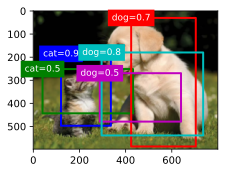

In [84]:
fig=d2l.plt.imshow(img)
show_bboxes(fig.axes,anchors*bbox_scale,['cat=0.9','cat=0.5','dog=0.7','dog=0.5','dog=0.8'])

In [85]:
output=multibox_detection(cls_probs.unsqueeze(dim=0),offset_preds.unsqueeze(dim=0),anchors.unsqueeze(dim=0),nms_threshold=0.4)
output
#背景为-1

torch.Size([5, 4]) torch.Size([5, 4])


tensor([[[ 1.00,  0.90,  0.15,  0.31,  0.42,  0.83],
         [ 0.00,  0.80,  0.37,  0.30,  0.92,  0.90],
         [-1.00,  0.50,  0.05,  0.42,  0.54,  0.74],
         [-1.00,  0.70,  0.53,  0.05,  0.88,  0.98],
         [-1.00,  0.50,  0.36,  0.45,  0.80,  0.80]]])

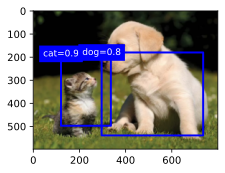

In [86]:
fig=d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] != -1:
        label=('dog=','cat=')[int(i[0])]+str(i[1])
        show_bboxes(fig.axes,[torch.tensor(i[2:])*bbox_scale],label)